In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
# from config import username, password
import time
from pathlib import Path
import pickle

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble.forest import RandomForestClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
import seaborn as sns
from collections import Counter

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

C:\Users\Rob\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Rob\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rob\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C

In [2]:
# Import the data
file_path = "Resources/Cleaned_Accidents_Data.csv"
cleaned_df = pd.read_csv(file_path)
cleaned_df.head()

,Severity,Latitude,Longitude,State,Zipcode,Country,Temperature_F,Visibility_miles,Wind_Speed_mph,Precipitation_inches,...,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Year,Month,Time,Part_of_Week,Time_of_Day
0,3,39.865147,-84.058723,OH,45424,US,36.9,10.0,0.0,0.02,...,False,False,False,False,False,2016,February,5,Weekday,Early Morning
1,2,39.928059,-82.831184,OH,43068,US,37.9,10.0,0.0,0.00,...,False,False,False,False,False,2016,February,6,Weekday,Early Morning
2,2,39.063148,-84.032608,OH,45176,US,36.0,10.0,3.5,0.00,...,False,False,False,True,False,2016,February,6,Weekday,Early Morning
3,3,39.747753,-84.205582,OH,45417,US,35.1,9.0,4.6,0.00,...,False,False,False,False,False,2016,February,7,Weekday,Early Morning
4,2,39.627781,-84.188354,OH,45459,US,36.0,6.0,3.5,0.00,...,False,False,False,True,False,2016,February,7,Weekday,Early Morning


In [3]:
filtered_cleaned_df = cleaned_df.drop(['Country'], axis=1)

In [4]:
# Define target vector
X = filtered_cleaned_df.copy()
X = filtered_cleaned_df.drop('Severity', axis=1)
y = filtered_cleaned_df['Severity']
y[:5]

0    3
1    2
2    2
3    3
4    2
Name: Severity, dtype: int64

In [5]:
X.head()

,Latitude,Longitude,State,Zipcode,Temperature_F,Visibility_miles,Wind_Speed_mph,Precipitation_inches,Weather_Condition,Speed_Bump,...,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Year,Month,Time,Part_of_Week,Time_of_Day
0,39.865147,-84.058723,OH,45424,36.9,10.0,0.0,0.02,Light Rain,False,...,False,False,False,False,False,2016,February,5,Weekday,Early Morning
1,39.928059,-82.831184,OH,43068,37.9,10.0,0.0,0.00,Light Rain,False,...,False,False,False,False,False,2016,February,6,Weekday,Early Morning
2,39.063148,-84.032608,OH,45176,36.0,10.0,3.5,0.00,Overcast,False,...,False,False,False,True,False,2016,February,6,Weekday,Early Morning
3,39.747753,-84.205582,OH,45417,35.1,9.0,4.6,0.00,Mostly Cloudy,False,...,False,False,False,False,False,2016,February,7,Weekday,Early Morning
4,39.627781,-84.188354,OH,45459,36.0,6.0,3.5,0.00,Mostly Cloudy,False,...,False,False,False,True,False,2016,February,7,Weekday,Early Morning


In [6]:
X = pd.get_dummies(data=X, columns=['Time_of_Day', 
                                    'Part_of_Week',
                                    'Month',
                                    'Turning_Loop',
                                    'Traffic_Light',
                                    'Traffic',
                                    'Stop_Sign',
                                    'Roundabout',
                                    'Year',
                                    'Weather_Condition',
                                    'State', 
                                    'Cross_Walk', 
                                    'Speed_Bump', 
                                    'Yield_Sign', 
                                    'Intersection', 
                                    'Railway', 
                                    'No_Exit'])

X = X.dropna()
X.head()

,Latitude,Longitude,Zipcode,Temperature_F,Visibility_miles,Wind_Speed_mph,Precipitation_inches,Time,Time_of_Day_Afteroon,Time_of_Day_Early Morning,...,Speed_Bump_False,Speed_Bump_True,Yield_Sign_False,Yield_Sign_True,Intersection_False,Intersection_True,Railway_False,Railway_True,No_Exit_False,No_Exit_True
0,39.865147,-84.058723,45424,36.9,10.0,0.0,0.02,5,0,1,...,1,0,1,0,1,0,1,0,1,0
1,39.928059,-82.831184,43068,37.9,10.0,0.0,0.00,6,0,1,...,1,0,1,0,1,0,1,0,1,0
2,39.063148,-84.032608,45176,36.0,10.0,3.5,0.00,6,0,1,...,1,0,1,0,1,0,1,0,1,0
3,39.747753,-84.205582,45417,35.1,9.0,4.6,0.00,7,0,1,...,1,0,1,0,1,0,1,0,1,0
4,39.627781,-84.188354,45459,36.0,6.0,3.5,0.00,7,0,1,...,1,0,1,0,1,0,1,0,1,0


In [7]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, train_size=0.80)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2740454, 229)
(685114, 229)
(2740454,)
(685114,)


In [9]:
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Random Forest Classifier

In [10]:
# Create a random forest classifier.
rf_model = RandomForestClassifier()
rf_model = RandomForestClassifier(n_estimators=500, random_state=78, verbose=3, max_depth = 10) 

In [11]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 58.3min finished


In [12]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)
predictions

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   46.5s finished


array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [13]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2", "Actual 3", "Actual 4"], 
    columns=["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])

In [14]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [15]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 1,144,5650,31,0
Actual 2,8,459108,4433,0
Actual 3,0,182502,11694,0
Actual 4,2,19475,2067,0


Accuracy Score: 0.6873980096743024
Classification Report


C:\Users\Rob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.94      0.02      0.05      5825
           2       0.69      0.99      0.81    463549
           3       0.64      0.06      0.11    194196
           4       0.00      0.00      0.00     21544

    accuracy                           0.69    685114
   macro avg       0.57      0.27      0.24    685114
weighted avg       0.66      0.69      0.58    685114



In [16]:
# Print the feature importances from the Random Forest classifier
feature_names = X.columns
sorted(zip(rf_model.feature_importances_, feature_names), reverse=True)

[(0.13426497067806012, 'Traffic_Light_False'),
 (0.13305310468207307, 'Traffic_Light_True'),
 (0.07567367526433572, 'Zipcode'),
 (0.06299974737969805, 'Longitude'),
 (0.05454637818239672, 'Cross_Walk_False'),
 (0.05023848320791942, 'Part_of_Week_Weekend'),
 (0.04945675552148799, 'Cross_Walk_True'),
 (0.047105633256479484, 'Latitude'),
 (0.0456437719989327, 'Part_of_Week_Weekday'),
 (0.032060087626056, 'State_GA'),
 (0.029001863318609263, 'Year_2020'),
 (0.022361304286018183, 'Weather_Condition_Fair'),
 (0.021731458732919158, 'State_NC'),
 (0.020271525922860297, 'State_OR'),
 (0.015033942874905153, 'State_CA'),
 (0.012820385552632629, 'Time'),
 (0.012267888505511398, 'Year_2019'),
 (0.011300869810911482, 'Stop_Sign_True'),
 (0.011192511880857544, 'Stop_Sign_False'),
 (0.010734005579734803, 'State_SC'),
 (0.009115741605188509, 'State_MO'),
 (0.008921420821695392, 'Intersection_True'),
 (0.008841356193320299, 'Intersection_False'),
 (0.008775807655919208, 'Year_2018'),
 (0.007903442663542

In [17]:
print('Accuracy of random forest on training: ', rf_model.score(X_train_scaled, y_train))
print('Accuracy of random forest on testing: ', rf_model.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.1min finished


Accuracy of random forest on training:  0.6876754727501355


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Accuracy of random forest on testing:  0.6766012663585914


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   32.1s finished


No handles with labels found to put in legend.


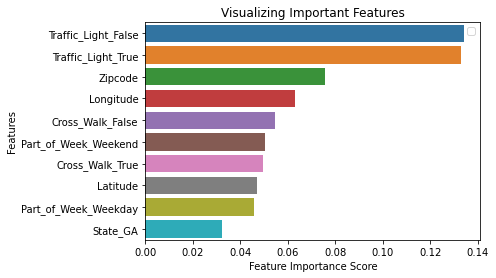

In [18]:
rf_features = pd.Series(rf_model.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=rf_features[:10], y=rf_features.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [19]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

C:\Users\Rob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

          1       0.94      0.02      1.00      0.05      0.16      0.02      5825
          2       0.69      0.99      0.06      0.81      0.25      0.07    463549
          3       0.64      0.06      0.99      0.11      0.24      0.05    194196
          4       0.00      0.00      1.00      0.00      0.00      0.00     21544

avg / total       0.66      0.69      0.36      0.58      0.24      0.06    685114



In [20]:
# Saving model to disk
pickle.dump(rf_model, open('random_forest_model_500n.pkl','wb'))

# Logistic Regression Classifier

In [21]:
logistic_regression = LogisticRegression()

In [22]:
# Fit the classifier
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [23]:
# Calculate the score for the test data
print('Accuracy of logistic regression on training: ', logistic_regression.score(X_train_scaled, y_train))
print('Accuracy of logistic regression on testing: ', logistic_regression.score(X_test, y_test))

Accuracy of logistic regression on training:  0.3104124353118133
Accuracy of logistic regression on testing:  0.6766027259696926


In [24]:
# Saving model to disk
pickle.dump(logistic_regression, open('logist_regression_model.pkl','wb'))

# K-Nearest Neighbors

In [25]:
# Create a K-NN classifier
knn = KNeighborsClassifier(n_neighbors=100)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels
y_pred = knn.predict(X_test)

In [26]:
accuracy_knn=[]

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_knn.append(acc)

print('Accuracy of K-Nearest Neighbors on training: ', knn.score(X_train_scaled, y_train))
print('Accuracy of K-Nearest Neighbors on testing: ', knn.score(X_test, y_test))

Accuracy of K-Nearest Neighbors on training:  0.6766159913649344
Accuracy of K-Nearest Neighbors on testing:  0.7226607542686326


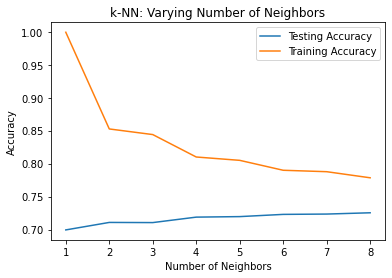

In [27]:
# Store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a K-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [37]:
# Saving model to disk
pickle.dump(knn, open('knn_model.pkl', 'wb'), protocol=4)

# Machine Learning Summary

In [29]:
print('Accuracy of K-Nearest Neighbors on training: ', knn.score(X_train_scaled, y_train))
print('Accuracy of K-Nearest Neighbors on testing: ', knn.score(X_test, y_test))

print('Accuracy of logistic regression on training: ', logistic_regression.score(X_train_scaled, y_train))
print('Accuracy of logistic regression on testing: ', logistic_regression.score(X_test, y_test))

print('Accuracy of random forest on training: ', rf_model.score(X_train_scaled, y_train))
print('Accuracy of random forest on testing: ', rf_model.score(X_test, y_test))

Accuracy of K-Nearest Neighbors on training:  0.6766159913649344
Accuracy of K-Nearest Neighbors on testing:  0.7254165000277326
Accuracy of logistic regression on training:  0.3104124353118133
Accuracy of logistic regression on testing:  0.6766027259696926


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.2min finished


Accuracy of random forest on training:  0.6876754727501355


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Accuracy of random forest on testing:  0.6766012663585914


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   32.7s finished


# Neural Network

In [30]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [31]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every 1 epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=2740454)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train,callbacks=[cp_callback], epochs=100)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
2739904/2740454 [============================>.] - ETA: 0s - loss: -216810141.2158 - acc: 0.0084
Epoch 00001: saving model to checkpoints/weights.01.hdf5
2740454/2740454 [==============================] - 112s 41us/sample - loss: -216930720.3844 - acc: 0.0084
Epoch 2/100
2739776/2740454 [============================>.] - ETA: 0s - loss: -2837401790.7360 - acc: 0.0084
Epoch 00002: saving model to checkpoints/weights.02.hdf5
2740454/2740454 [==============================] - 111s 41us/sample - loss: -2838151039.2941 - acc: 0.0084
Epoch 3/100
2739296/2740454 [============================>.] - ETA: 0s - loss: -11624045457.3078 - acc: 0.0084
Epoch 00003: saving model to checkpoints/weights.03.hdf5
2740454/2740454 [==============================] - 111s 41us/sample - loss

Epoch 28/100
2739808/2740454 [============================>.] - ETA: 0s - loss: -13191746943900.3379 - acc: 0.0084
Epoch 00028: saving model to checkpoints/weights.28.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -13191815372726.2305 - acc: 0.0084
Epoch 29/100
2739392/2740454 [============================>.] - ETA: 0s - loss: -14663982785623.0098 - acc: 0.0084
Epoch 00029: saving model to checkpoints/weights.29.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -14664097334183.9102 - acc: 0.0084
Epoch 30/100
2739808/2740454 [============================>.] - ETA: 0s - loss: -16241745904999.7207 - acc: 0.0084
Epoch 00030: saving model to checkpoints/weights.30.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -16241716673826.5840 - acc: 0.0084
Epoch 31/100
2739488/2740454 [============================>.] - ETA: 0s - loss: -17928815400947.6797 - acc: 0.0084
Epoch 00031: saving model to checkpo

Epoch 57/100
2739712/2740454 [============================>.] - ETA: 0s - loss: -112163416765927.7969 - acc: 0.0084
Epoch 00057: saving model to checkpoints/weights.57.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -112164689591161.1875 - acc: 0.0084
Epoch 58/100
2740032/2740454 [============================>.] - ETA: 0s - loss: -118192372705809.2031 - acc: 0.0084
Epoch 00058: saving model to checkpoints/weights.58.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -118192743518794.1250 - acc: 0.0084
Epoch 59/100
2740288/2740454 [============================>.] - ETA: 0s - loss: -124436469613251.9062 - acc: 0.0084
Epoch 00059: saving model to checkpoints/weights.59.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -124436672499735.7812 - acc: 0.0084
Epoch 60/100
2739456/2740454 [============================>.] - ETA: 0s - loss: -130894688665448.4219 - acc: 0.0084
Epoch 00060: saving model to 

Epoch 86/100
2739744/2740454 [============================>.] - ETA: 0s - loss: -386670223808765.8750 - acc: 0.0084
Epoch 00086: saving model to checkpoints/weights.86.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -386670291202917.1875 - acc: 0.0084
Epoch 87/100
2739968/2740454 [============================>.] - ETA: 0s - loss: -400351046431684.0000 - acc: 0.0084
Epoch 00087: saving model to checkpoints/weights.87.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -400349449887219.2500 - acc: 0.0084
Epoch 88/100
2739936/2740454 [============================>.] - ETA: 0s - loss: -414345011541795.5625 - acc: 0.0084
Epoch 00088: saving model to checkpoints/weights.88.hdf5
2740454/2740454 [==============================] - 110s 40us/sample - loss: -414349117677031.7500 - acc: 0.0084
Epoch 89/100
2740416/2740454 [============================>.] - ETA: 0s - loss: -428672131735525.4375 - acc: 0.0084
Epoch 00089: saving model to 

In [40]:
# Make predictions
predicted = nn.predict(X_test_scaled)
predicted = inverse_transform(predicted).flatten().tolist()
results = pd.DataFrame({
    "Actual": y_test.activity.values,
    "Predicted": predicted
})
results.head(10)

NameError: name 'inverse_transform' is not defined

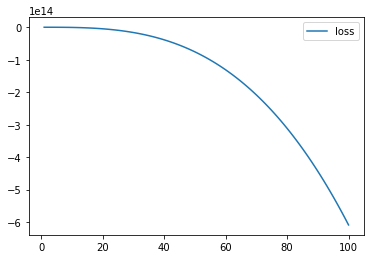

In [53]:
# Plotting graphs
df_plot = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"]) + 1))

df_plot.plot(y="loss")

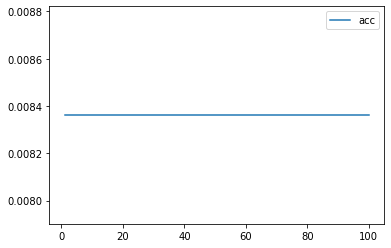

In [57]:
# Plot the loss
df_plot.plot(y="acc")

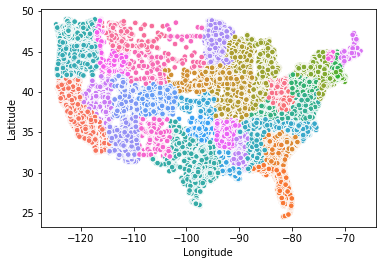

In [55]:
# Map of accidents, color code by State
sns.scatterplot(x='Longitude', y='Latitude', data=cleaned_df, hue='State', legend=False, s=30)
plt.show()

In [44]:
# Export our model to HDF5 file
nn.save("final_project_nn.h5")

In [52]:
# Loading model to compare results
model_accident = pickle.load( open('random_forest_model_500n.pkl','rb'))
print(model_accident.predict([[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]]))

[2]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


In [59]:
# iterating the columns 
for col in X.columns: 
    print(col) 

Latitude
Longitude
Zipcode
Temperature_F
Visibility_miles
Wind_Speed_mph
Precipitation_inches
Time
Time_of_Day_Afteroon
Time_of_Day_Early Morning
Time_of_Day_Late Afternoon
Time_of_Day_Late Night
Time_of_Day_Morning
Time_of_Day_Night
Part_of_Week_Weekday
Part_of_Week_Weekend
Month_April
Month_August
Month_December
Month_February
Month_January
Month_July
Month_June
Month_March
Month_May
Month_November
Month_October
Month_September
Turning_Loop_False
Traffic_Light_False
Traffic_Light_True
Traffic_False
Traffic_True
Stop_Sign_False
Stop_Sign_True
Roundabout_False
Roundabout_True
Year_2016
Year_2017
Year_2018
Year_2019
Year_2020
Weather_Condition_Blowing Dust
Weather_Condition_Blowing Dust / Windy
Weather_Condition_Blowing Sand
Weather_Condition_Blowing Snow
Weather_Condition_Blowing Snow / Windy
Weather_Condition_Clear
Weather_Condition_Cloudy
Weather_Condition_Cloudy / Windy
Weather_Condition_Drifting Snow
Weather_Condition_Drizzle
Weather_Condition_Drizzle / Windy
Weather_Condition_Driz